In [55]:
# Libraries
import os, io, time, requests
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from tabpfn import TabPFNRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [56]:
# Configurations
'''
Without it, TabPFN (a machine learning library) will refuse to run if the dataset has more than 1,000 rows on a CPU.
'''
#os.environ["TABPFN_ALLOW_CPU_LARGE_DATASET"] = "1" 

'\nWithout it, TabPFN (a machine learning library) will refuse to run if the dataset has more than 1,000 rows on a CPU.\n'

In [57]:
DATASET = "../epidemic_curve.csv"

In [58]:
'''
parse_dates argument ensures that the "date" column is read as datetime objects.
set_index argument sets the "Date" column as the index of the DataFrame.
sort_index argument sorts the DataFrame by the index (dates) in ascending order.
'''
df = (
    pd.read_csv(DATASET, parse_dates=["date"])
    .rename(columns={"date": "Date", "cases": "Value"})
    .set_index("Date")
    .sort_index()
)

In [59]:
df["week"]=df.index.isocalendar().week.astype(int) # Add week number column
df["run_idx"] = np.arange(len(df)) / len(df) # It’s a simple trend feature (time-progress indicator), scaled between 0 and 1 


`df["run_idx"] = np.arange(len(df)) / len(df)`

- Creates a column with numbers from 0 to 1 representing progress through the dataset
- np.arange(len(df)) makes [0, 1, 2, 3, ..., last_row]
- Dividing by len(df) normalizes it to [0, 0.01, 0.02, ..., 1.0]

In [60]:
df.tail()

,Value,week,run_idx
Date,,,
2024-09-02,33,36,0.875
2024-09-09,0,37,0.900
2024-09-16,0,38,0.925
2024-09-23,0,39,0.950
2024-09-30,66,40,0.975


We can see run_idx is creasing from first week to last week so using that we can check the cases is increasing at the end of the week or its decreasing. If the cases are so random then we can ignore it for sure so its an option feature for us.


In [61]:
# Split the data into training and testing sets

HORIZON = 4  # forecast 4 weeks ahead
train, test = df.iloc[:-HORIZON], df.iloc[-HORIZON:]
'''
df.iloc[:-HORIZON] = All rows EXCEPT the last 16 → training data
df.iloc[-HORIZON:] = The last 16 rows → testing data
'''

X_tr, y_tr  = train.drop(columns="Value"), train["Value"]
X_te, y_te  = test.drop(columns="Value"),  test["Value"]
'''
.drop() Takes all columns EXCEPT "Value"

X_tr = Features (inputs): the "month" and "run_idx" columns
y_tr = Target (what we're predicting): the "Value" column 
Same split for test: X_te and y_te
'''


'\n.drop() Takes all columns EXCEPT "Value"\n\nX_tr = Features (inputs): the "month" and "run_idx" columns\ny_tr = Target (what we\'re predicting): the "Value" column \nSame split for test: X_te and y_te\n'

### trains and predicts with TabPFN model


In [62]:
# create the model
tab = TabPFNRegressor(device="cpu", ignore_pretraining_limits=True) # Use "cpu" if no GPU available ("mps" might not work with TabPFN )
'''
a TabPFN model to make predictions with uncertainty estimates.
What are "uncertainty estimates"?
-> The model does nto say the answer is this, but rather "the answer is this, with this much confidence". I mean, it says:
    Median (best guess): 1500 housing starts
    10th percentile (low): 1300 housing starts
    90th percentile (high): 1700 housing starts
So, the model is saying "I'm 80% sure the true value lies between 1300 and 1700 housing starts", which helps to understand how confident the model is in its prediction.

In short, Wide range = uncertain, narrow range = confident.

*** ignore_pretraining_limits=True removes internal data-size limits (helpful for >1 000 rows).

We can check with ingore_pretraining_limits=False as we don't have big number of rows which also give us good result but may give us error if too many rows are there.

'''

'\na TabPFN model to make predictions with uncertainty estimates.\nWhat are "uncertainty estimates"?\n-> The model does nto say the answer is this, but rather "the answer is this, with this much confidence". I mean, it says:\n    Median (best guess): 1500 housing starts\n    10th percentile (low): 1300 housing starts\n    90th percentile (high): 1700 housing starts\nSo, the model is saying "I\'m 80% sure the true value lies between 1300 and 1700 housing starts", which helps to understand how confident the model is in its prediction.\n\nIn short, Wide range = uncertain, narrow range = confident.\n\n*** ignore_pretraining_limits=True removes internal data-size limits (helpful for >1 000 rows).\n\nWe can check with ingore_pretraining_limits=False as we don\'t have big number of rows which also give us good result but may give us error if too many rows are there.\n\n'

In [63]:
# Train the model
tab.fit(X_tr.values, y_tr.values)
'''
Trains the model using your training features (X_tr) and target (y_tr = weekly cases)

.values --> converts pandas DataFrames to numpy arrays (what TabPFN expects)

Model learns: "When week=36 and run_idx=0.875, Value is usually around X"
'''

'\nTrains the model using your training features (X_tr) and target (y_tr = weekly cases)\n\n.values --> converts pandas DataFrames to numpy arrays (what TabPFN expects)\n\nModel learns: "When week=36 and run_idx=0.875, Value is usually around X"\n'

In [64]:
# Make predictions
y_tab = tab.predict(X_te.values, output_type="median")
'''
Predicts future case values (median forecast)

output_type="median" = gives the middle estimate (50th percentile)
'''

'\nPredicts future case values (median forecast)\n\noutput_type="median" = gives the middle estimate (50th percentile)\n'

In [65]:
# Get uncertainty range
q10, q90 = tab.predict(X_te.values, output_type="quantiles", quantiles=[0.1, 0.9])
'''
Gives uncertainty bounds — Creates an 80% confidence interval (between 10% and 90%)
'''

'\nGives uncertainty bounds — Creates an 80% confidence interval (between 10% and 90%)\n'

#### Check with different metrics

In [66]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

mae  = mean_absolute_error(y_te, y_tab) # Mean Absolute Error: average absolute difference between predicted and actual values
mse  = np.mean((y_te - y_tab)**2) # Mean Squared Error: average squared difference between predicted and actual values
rmse = np.sqrt(mse) # Root Mean Squared Error: square root of MSE, gives error in original units
r2   = r2_score(y_te, y_tab) # R-squared: how good the model fit is (R^2=1 means perfect && R^2 = 0 means poor).

print("=== TabPFN Model Performance ===")
print(f"MAE   : {mae:.2f}")
print(f"MSE   : {mse:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"R²    : {r2:.3f}")
print("===============================")



=== TabPFN Model Performance ===
MAE   : 23.06
MSE   : 758.75
RMSE  : 27.55
R²    : 0.071


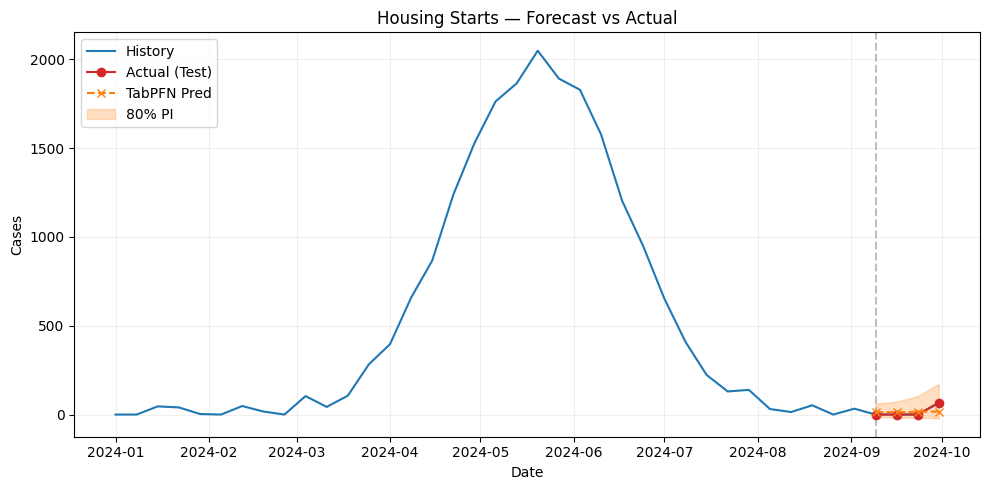

In [69]:
# Simple chart with train/test split and predictions
plt.figure(figsize=(10,5))

# History
plt.plot(df.index, df["Value"], label="History", linewidth=1.5)

# Train/test split line
plt.axvline(test.index[0], color="gray", linestyle="--", alpha=0.5)

# Actual test values
plt.plot(y_te.index, y_te, "o-", label="Actual (Test)", color="C3")

# TabPFN predictions
plt.plot(y_te.index, y_tab, "x--", label="TabPFN Pred", color="C1")
plt.fill_between(y_te.index, q10, q90, alpha=0.25, color="C1", label="80% PI")

plt.title("Housing Starts — Forecast vs Actual")
plt.ylabel("Cases")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Predicting the next 4 weeeks beyond our dataset

In [ ]:
# === Forecast next 4 weeks beyond last observed date ===

last_date = df.index[-1] # We set date as index before and to get the last date in the dataset
n_future = 4  # predict 4 weeks ahead

# future weekly dates based on the data's frequency
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                             periods=n_future, freq='W')
'''
pd.date_range() --> Creates a sequence of dates like a calendar generator
start=last_date + pd.Timedelta(weeks=1) --> Start one week after the last data point so, if 
last date = 2024-09-30 → start = 2024-10-07
periods=n_future --> How many dates to generate (4 weeks in our case)
freq='W' --> Frequency is weekly (every 7 days)

Remember it: 

start + step, repeat, freq → date_range
start → where to begin
step → how far ahead to start (+1 week)
repeat → how many points (periods=n_future)
freq → how often ('W' for weekly, 'M' for monthly, 'D' for daily)
'''

# continue run_idx progression (normalized timeline)
n_total = len(df) # total number of rows in original data
future_run_idx = (np.arange(n_total, n_total + n_future) / (n_total + n_future)).tolist()
'''
future_run_idx --> extends the run_idx feature

n_total = len(df) is the total number of rows in the original dataset. <eg: 100>
np.arange(n_total, n_total + n_future) --> Creates numbers starting where data ended. <eg: [100, 101, 102, 103] for next 4 weeks>
/ (n_total + n_future) --> Normalizes to 0-1 range

example: [100/104, 101/104, 102/104, 103/104] = [0.96, 0.97, 0.98, 0.99]

run_idx going from 0 → ~0.96
This continues it: ~0.96 → 0.97 → 0.98 → 0.99

Same idea - continuing the timeline!
'''

# compute week numbers for future dates
future_weeks = future_dates.isocalendar().week.astype(int).tolist()
'''
.isocalendar() = get ISO calendar info (year, week, day)
.week = grab just the week number
.astype(int) = convert to integer (1, 2, 3... 52)
.tolist() = convert to Python list

example:
Date: 2024-10-27 → Week 43 (just an example)

'''

# build future feature frame (same structure as X_tr)
future_df = pd.DataFrame({
    "week": future_weeks,
    "run_idx": future_run_idx
}, index=future_dates)

# predict next 4 weeks
y_future = tab.predict(future_df.values, output_type="median")

# if quantiles available
try:
    q10_f, q90_f = tab.predict(future_df.values, output_type="quantiles", quantiles=[0.1, 0.9])
except Exception:
    q10_f = q90_f = None

# display
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Cases": np.round(y_future, 2),
    "Lower_80PI": np.round(q10_f, 2) if q10_f is not None else None,
    "Upper_80PI": np.round(q90_f, 2) if q90_f is not None else None
})
print("=== 4-Week Forecast ===")
print(forecast_df)


=== 4-Week Forecast ===
        Date  Predicted_Cases  Lower_80PI  Upper_80PI
0 2024-10-13            15.92  -19.790001  116.940002
1 2024-10-20            18.68  -21.270000  202.419998
2 2024-10-27            22.73  -21.010000  461.309998
3 2024-11-03            26.51  -22.690001  726.979980


**Lower_80PI(10th Percentile)** <br>
-ve value which is problem because cases can't be negative cases.

**Upper_80PI(90th Percentile)**<br>
gets wider nevry next week (117->727)

**Good Point**<br>
The Predicted_cases gradual increase from 16 to 27

##### Concerns:

- Huge uncertainty ranges - prediction could be anywhere from -20 to 700+
- Negative lower bounds - physically impossible (bad sign)
- Uncertainty explodes - Week 4 range is 750 units wide!


### Autoregressive 4-week forecast (use lag features)

In [ ]:
# Autoregressive 4-week forecast using lag features (run in inserm kernel)
import pandas as pd, numpy as np
from tabpfn import TabPFNRegressor
from pathlib import Path

CSV = "epidemic_curve.csv"

# 1) Build weekly series and supervised data (lags + target)
LAGS = 8
HORIZON = 4
raw = pd.read_csv(CSV, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
weekly = raw.set_index("date")["cases"].resample("W-MON").sum().reset_index().rename(columns={"cases":"value"})

# build lags
ws = weekly.copy()
for i in range(1, LAGS+1):
    ws[f"lag_{i}"] = ws["value"].shift(i)
# optional extra features
ws["weekofyear"] = ws["date"].dt.isocalendar().week.astype(int)
# target: 4-week ahead
ws["target_h4"] = ws["value"].shift(-HORIZON)
supervised = ws.dropna().reset_index(drop=True)

feature_cols = [f"lag_{i}" for i in range(1, LAGS+1)] + ["weekofyear"]
X_all = supervised[feature_cols].to_numpy()
y_all = supervised["target_h4"].to_numpy()

print("Supervised rows:", len(supervised), "| Features:", feature_cols)

# 2) Train final TabPFN on all supervised rows (use all data for best forecast)
model = TabPFNRegressor(device="cpu", ignore_pretraining_limits=True)  # use "cpu" for stability
model.fit(X_all, y_all)
# save if needed
import joblib
joblib.dump(model, OUT/"tabpfn_autoreg_final.joblib")

# 3) Build the last raw feature vector (latest observed weeks -> lag_1..lag_8)
last_idx = len(weekly) - 1
if last_idx < LAGS:
    raise ValueError("Not enough raw weekly values to construct LAGS. Need >= LAGS+1 weeks.")

# collect last LAGS observed raw values: lag_1 is 1 week before last observed, etc.
lag_vals = [weekly.loc[last_idx - i, "value"] for i in range(1, LAGS+1)]

# construct raw feature vector in same order as training
x_raw = np.array(lag_vals + [int(weekly.loc[last_idx,"date"].isocalendar().week)], dtype=float).reshape(1,-1)

# 4) Iteratively forecast next 4 weeks (autoregressive)
n_future = 4
future_preds = []
x_cur_raw = x_raw.copy()
for step in range(n_future):
    y_pred = float(model.predict(x_cur_raw)[0])
    y_pred = max(y_pred, 0.0)          # clamp negatives to 0
    future_preds.append(y_pred)
    # update raw lag window: drop oldest lag and append y_pred
    raw_lags = list(x_cur_raw[0, :LAGS])
    raw_lags = raw_lags[1:] + [y_pred]
    # keep calendar feature as rolling forward week number (optional: update weekofyear)
    next_week_num = int((weekly.loc[last_idx,"date"] + pd.Timedelta(weeks=step+1)).isocalendar().week)
    x_cur_raw = np.array(raw_lags + [next_week_num], dtype=float).reshape(1,-1)

# 5) Build forecast dataframe and show
future_dates = pd.date_range(start=weekly["date"].iloc[-1] + pd.Timedelta(weeks=1),
                             periods=n_future, freq="W-MON")
forecast_df = pd.DataFrame({"date": future_dates, "predicted_cases": np.round(future_preds,2)})
print("=== Autoregressive 4-week forecast ===")
print(forecast_df.to_string(index=False))
